# Earthquake seismology with DAS

#### Todo List:
1. Reference earthquakes by Evid rather than dataframe index
2. Make a map of all of the detected events
3. Try some xcorr
4. Focal Mechanisms


In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd
from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook, data_quicklook 
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from libcomcat.search import search
from libcomcat.dataframes import get_summary_data_frame
from tqdm import tqdm

### Get a list of events from USGS

In [2]:
events = search(starttime = datetime.datetime(2022, 3, 17, 0, 0), 
                endtime   = datetime.datetime.now(),
                maxradiuskm=1000, 
                latitude=47.60, 
                longitude=-122.33)

#events = search(starttime = datetime.datetime(2022, 9, 7, 0, 0), 
#                endtime   = datetime.datetime(2022, 9, 9, 0, 0),
#                maxradiuskm=1000, 
#                latitude=47.60, 
#                longitude=-122.33)

print("Returned %s events" % len(events))

Returned 16485 events


In [3]:
event_df = get_summary_data_frame(events)
event_df = event_df.sort_values(by=['magnitude'],ascending=False)
event_df.iloc[0:20]

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
6028,us7000hhik,2022-06-15 11:56:33.191,off the coast of Oregon,44.538100,-130.112400,10.00,5.60,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,487
2848,us6000hfx7,2022-04-23 21:22:47.948,"185 km W of Port McNeill, Canada",50.472500,-129.689500,10.00,5.30,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,435
5461,us7000hf29,2022-06-04 23:59:10.007,"Haida Gwaii Region, Canada",51.613700,-131.402700,6.61,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,401
768,us7000gxl1,2022-03-27 01:12:22.059,off the coast of Oregon,44.122900,-129.438500,10.00,5.10,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,404
12729,nc73785481,2022-09-24 19:27:39.450,"37km W of Petrolia, CA",40.313667,-124.724500,13.08,4.84,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,461
9062,us6000i90r,2022-08-08 07:38:56.410,"201 km W of Tofino, Canada",48.973600,-128.652200,10.00,4.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,326
5945,us7000hh4b,2022-06-13 17:34:43.012,"204 km W of Port McNeill, Canada",50.920200,-129.941400,10.00,4.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,326
8264,us7000hth5,2022-07-26 05:46:22.180,"Haida Gwaii Region, Canada",51.687200,-131.193100,10.00,4.60,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,326
11748,us7000i88d,2022-09-15 09:21:38.195,off the coast of Oregon,43.243600,-126.265300,10.00,4.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,300
6032,us7000hhiy,2022-06-15 13:18:41.414,off the coast of Oregon,44.505800,-130.151400,10.00,4.40,None,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,298


### Choose an event to analyze

In [4]:
detected_quakes = ['uw61835766','uw61832097','uw61836427',
                   'uw61846212','uw61819867','uw61850651','uw61855012']
# detected_quakes_whidbey = ['uw61832097','uw61819867','uw61855012','us7000gxl1']

# this_event_index = 0
# this_id=detected_quakes[this_event_index]

this_id = 'us7000hhik'

this_event = event_df[event_df.id==this_id]
t0 = this_event['time'].iloc[0]

this_event

,id,time,location,latitude,longitude,depth,magnitude,alert,url,eventtype,significance
6028,us7000hhik,2022-06-15 11:56:33.191,off the coast of Oregon,44.5381,-130.1124,10.0,5.6,green,https://earthquake.usgs.gov/earthquakes/eventp...,earthquake,487


### Load the DAS Data

In [5]:
cable = 'seadasn'
#cable = 'whidbey'
record_length = 10 #minutes

if cable == 'seadasn':
    prefix = 'seadasn'
    network_name = 'SeaDAS-N'
    if t0 < datetime.datetime(2022, 6, 20, 0, 0, 0):
        datastore='/data/data0/seadasn_2022-03-17_2022-06-20/'
    else:
        datastore='/data/data7/seadasn/'
        
elif cable == 'whidbey':
    prefix = 'whidbey'
    network_name='Whidbey-DAS'
    datastore = '/data/data5/Converted/'

data,dates,attrs = open_sintela_file(prefix,
                                     t0,
                                     datastore,
                                     number_of_files=record_length,
                                     verbose=True)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_11-56*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_11-57*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_11-58*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_11-59*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-00*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-01*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-02*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-03*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-04*.h5
/data/data0/seadasn_2022-03-17_2022-06-20/seadasn_2022-06-15_12-05*.h5


In [6]:
data

array([[ 2.4455104 ,  0.7069179 ,  0.8545533 , ...,  0.1908038 ,
         0.213634  ,  0.18717828],
       [ 2.4728365 ,  0.57969916,  1.5263572 , ...,  0.19497253,
         0.21116981,  0.21097247],
       [ 2.5199878 ,  0.2618932 ,  0.9522387 , ...,  0.17700034,
         0.22061262,  0.20576084],
       ...,
       [-3.81151   ,  0.4448767 ,  0.7053587 , ..., -0.18556654,
        -0.18827406, -0.19702104],
       [-3.7844563 ,  0.42788637,  0.8527104 , ..., -0.18574826,
        -0.1890963 , -0.18321489],
       [-3.7565649 , -0.7915309 , -0.5963481 , ..., -0.14837289,
        -0.19604678, -0.19224782]], dtype=float32)

In [30]:
low_cut = 0.01
hi_cut = 2

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [31]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=record_length)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
# st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "HH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.HH1 | 2022-06-15T11:56:33.008393Z - 2022-06-15T12:06:32.998393Z | 100.0 Hz, 60000 samples

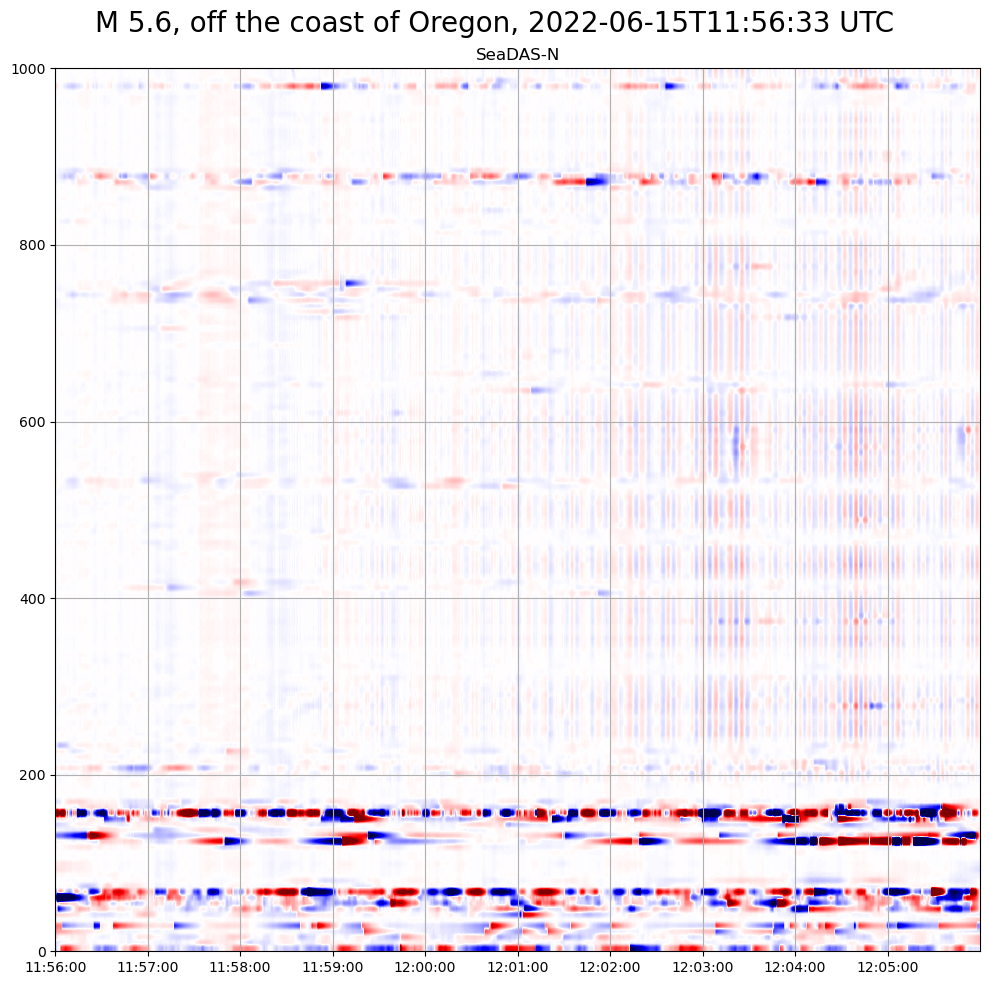

In [58]:
stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"

data_quicklook(dates,data_filt,x_max,stitle,filename=None,das_vmax=10,network_name=network_name,ylim=[0,1000])

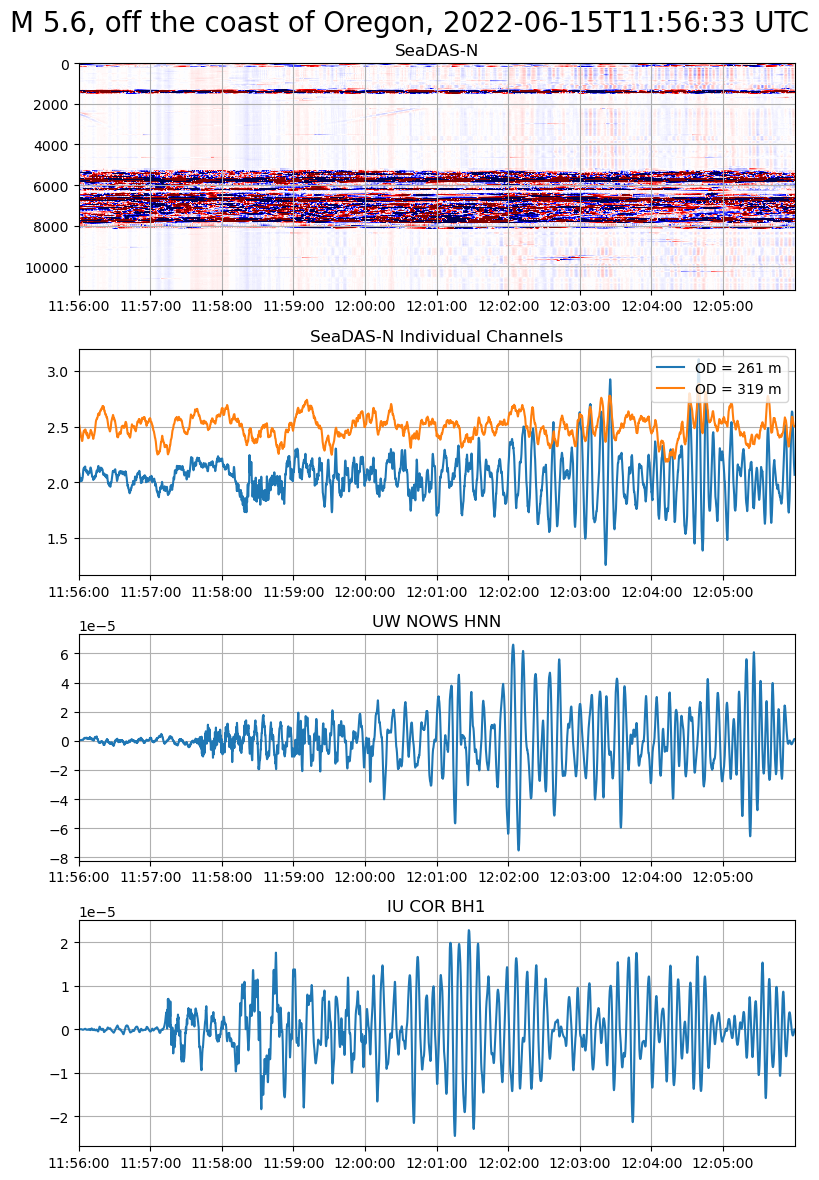

In [61]:
# nombre = f"figures/{event_df.iloc[catalog_index]['Evid']}.png"
# local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index,filename=nombre)

#vmax=0.02
stitle=f"M {this_event['magnitude'].to_numpy()[0]}, "\
       f"{this_event['location'].to_numpy()[0]}, "\
       f"{str(this_event['time'].to_numpy()[0])[0:-10]} UTC"


local_earthquake_quicklook(dates,data_filt,st,st2,x_max,
                           stitle,das_vmax=5,
                           network_name=network_name)

In [62]:
np.correlate([1, 2, 3], [0, 1, 0.5])

array([3.5])

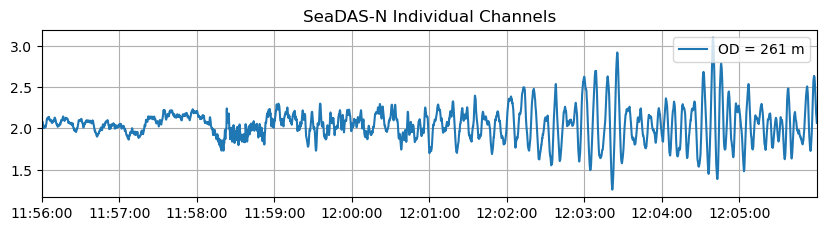

In [34]:
    low_cut = 0.01
    hi_cut = 2

    b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
    data_filt = filtfilt(b,a,data,axis=0)
    
    import matplotlib.dates as mdates
    dx = x_max / data_filt.shape[1]
    fig,ax=plt.subplots(figsize=(10,10))
    date_format = mdates.DateFormatter('%H:%M:%S')
    
    ax = plt.subplot(4,1,1)
    fig.patch.set_facecolor('w')
    graph_spacing = -20
    #,400,800,1400
    jj=41
    plt.plot(dates,data_filt[:,jj]-jj/graph_spacing,label=f'OD = {int(jj*dx)} m')
    plt.legend(loc='upper right')
    ax.set_title(f'{network_name} Individual Channels')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis_date()
    ax.autoscale(enable=True, axis='x', tight=True)
    plt.grid()

In [56]:
this_event.url.to_list()[0]
len(data_filt)
data_filt

array([[-1.27892308, -0.17736357,  0.30101493, ...,  0.02891749,
         0.0370224 ,  0.03196922],
       [-1.26835507, -0.20254599,  0.32199089, ...,  0.02938814,
         0.03693097,  0.03314533],
       [-1.25768106, -0.2270319 ,  0.34267436, ...,  0.0298721 ,
         0.03682338,  0.0343103 ],
       ...,
       [-0.08193884,  0.55924083,  0.54214897, ..., -0.02965661,
        -0.00433689, -0.01290474],
       [-0.07226202,  0.49474965,  0.47961447, ..., -0.02608248,
        -0.00369753, -0.01130126],
       [-0.06291827,  0.43088498,  0.41769273, ..., -0.0226073 ,
        -0.0031379 , -0.00978034]])

In [39]:
from tqdm import tqdm
xc = np.zeros((119999,174))

for i in tqdm(range(174)):
    xc[:,i] = np.correlate(np.sign(data_filt[:,30]),
                           np.sign(data_filt[:,i*10]),
                           mode='full')

100%|██████████| 174/174 [07:32<00:00,  2.60s/it]


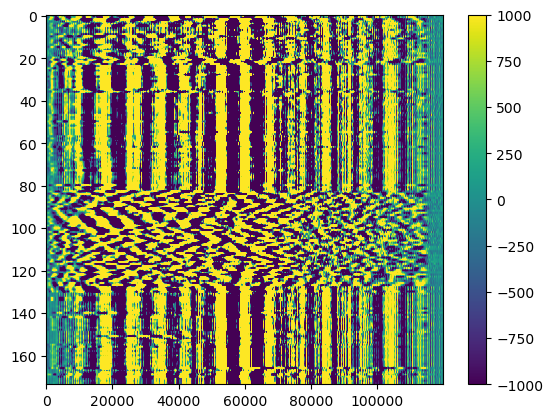

In [63]:
fig,ax=plt.subplots()
plt.imshow(xc.T,aspect='auto',vmin=-1000,vmax=1000)
# plt.plot(data_filt[:,30])
# plt.plot(data_filt[:,40])
#plt.xlim(18000-1e3,18000+1e3)
plt.colorbar()

In [69]:
tqdm(range(174))


  0%|          | 0/174 [00:00<?, ?it/s]

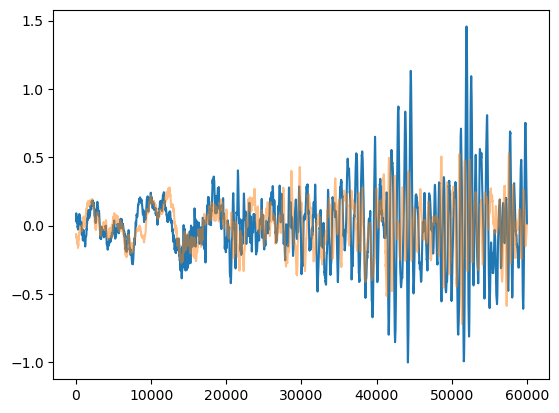

In [70]:
fig,ax=plt.subplots()
# plt.imshow(xc.T,aspect='auto',vmin=-0.1,vmax=0.1)
plt.plot(data_filt[:,40])
plt.plot(data_filt[:,30],alpha=0.5)
#plt.xlim(0,100)
plt.show()

In [71]:
a=1